#### Preparación de los datos

Se importa el conjunto de datos transformado y se realiza una limpieza básica:
- Se definen los datos de entrenamiento con las temporadas 2019-20 a 2022-23.
- Se separa el conjunto de prueba correspondiente a la temporada 2023-24.


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import OneHotEncoder

# Cargar dataset
df = pd.read_csv("../datasets/dataset_transformado.csv")

# Asegurar formatos correctos
df['date'] = pd.to_datetime(df['date']) 
df['season'] = df['season'].astype(str)   

# Separar conjuntos de entrenamiento y prueba
temporadas_entrenamiento = ['2019-20', '2020-21', '2021-22', '2022-23']
df_train = df[df['season'].isin(temporadas_entrenamiento)]
df_test = df[df['season'] == '2023-24']


#### Codificación de variables y construcción de la matriz de entrenamiento

- Se obtiene una lista ordenada de todos los equipos (locales y rivales) para codificarlos mediante one-hot encoding.
- Se aplica codificación one-hot por separado para el equipo (`team`) y su rival (`rival_team`).
- Se seleccionan variables numéricas relevantes que caracterizan tanto al equipo como al rival (estadísticas históricas, cuotas promedio, etc.).
- Se construye la matriz `X_train` combinando las variables categóricas codificadas y las numéricas.
- Las variables objetivo para la regresión de Poisson son los goles anotados por el equipo (`goals_team`) y por el rival (`goals_rival`).


In [2]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Lista de equipos (de 'team' y 'rival_team')
equipos = sorted(pd.unique(df[['team', 'rival_team']].values.ravel()))

# Codificador one-hot para equipos
encoder = OneHotEncoder(categories=[equipos], drop=None, sparse_output=False, handle_unknown='ignore')

# One-hot encoding para equipo local (team) y rival (rival_team)
X_team = encoder.fit_transform(df_train[['team']])
X_rival = encoder.transform(df_train[['rival_team']].rename(columns={'rival_team': 'team'}))

# Variables explicativas adicionales seleccionadas
features_numericas = [
    'home_adv',
    'pct_wins', 'avg_goals_scored', 'avg_goals_received', 'goal_difference',
    'pct_wins_rival', 'avg_goals_scored_rival', 'avg_goals_received_rival', 'goal_difference_rival',
    'pct_wins_vs_rival', 'avg_goals_scored_vs_rival', 'avg_goals_received_vs_rival', 'goal_difference_vs_rival',
    'AvgH', 'AvgD', 'AvgA'
]
X_features = df_train[features_numericas].values

# Concatenar todo: equipos + características numéricas
X_train = np.hstack([X_team, X_rival, X_features])

# Variables objetivo (goles del equipo y del rival)
y_train_home = df_train['goals_team']
y_train_away = df_train['goals_rival']


#### Entrenamiento de los modelos de Regresión de Poisson

- Se crean dos modelos de regresión de Poisson:
  - `model_home`: predice los goles esperados del equipo local (`goals_team`).
  - `model_away`: predice los goles esperados del equipo visitante (`goals_rival`).
- Se utiliza un valor muy pequeño de regularización (`alpha=1e-12`) para evitar penalización excesiva.
- Ambos modelos se ajustan (`fit`) utilizando la matriz de características `X_train` y sus respectivas variables objetivo.


In [3]:
model_home = PoissonRegressor(alpha=1e-12, max_iter=1000)
model_away = PoissonRegressor(alpha=1e-12, max_iter=1000)

model_home.fit(X_train, y_train_home)
model_away.fit(X_train, y_train_away)

PoissonRegressor(alpha=1e-12, max_iter=1000)

#### Preparación de datos de test y predicción de goles esperados

- Se aplica codificación one-hot a los equipos del conjunto de test (`team` y `rival_team`) utilizando el mismo codificador `encoder` usado en el entrenamiento.
- Se seleccionan las mismas variables numéricas utilizadas en `X_train`.
- Se combinan las codificaciones de equipos y las características numéricas para formar la matriz final de test `X_test`.
- Se predicen los goles esperados:
  - `lambda_home`: goles esperados del equipo local.
  - `mu_away`: goles esperados del equipo visitante.


In [4]:
from scipy.stats import poisson

# Codificación one-hot de equipos en test
X_team_test = encoder.transform(df_test[['team']])
X_rival_test = encoder.transform(df_test[['rival_team']].rename(columns={'rival_team': 'team'}))

# Variables numéricas usadas en entrenamiento
features_numericas = [
    'home_adv',
    'pct_wins', 'avg_goals_scored', 'avg_goals_received', 'goal_difference',
    'pct_wins_rival', 'avg_goals_scored_rival', 'avg_goals_received_rival', 'goal_difference_rival',
    'pct_wins_vs_rival', 'avg_goals_scored_vs_rival', 'avg_goals_received_vs_rival', 'goal_difference_vs_rival',
    'AvgH', 'AvgD', 'AvgA'
]

X_features_test = df_test[features_numericas].values

# Concatenar todo: equipos + variables numéricas
X_test = np.hstack([X_team_test, X_rival_test, X_features_test])

# Predecir goles esperados
lambda_home = model_home.predict(X_test)
mu_away = model_away.predict(X_test)


#### Simulación de resultados con distribución de Poisson

- Se ajustan los goles esperados (`lambda_home`, `mu_away`) mediante un `factor_calibracion` para controlar la dispersión (más empates).
- Para cada partido del conjunto de test:
  - Se construye una matriz conjunta de probabilidades de resultado utilizando las distribuciones de Poisson.
  - Se calculan las probabilidades de victoria local (`p_home_win`), empate (`p_draw`) y victoria visitante (`p_away_win`).
  - Se aplica una regla de decisión:
    - Si la probabilidad de empate es mayor que `umbral_empate`, se predice 'D'.
    - En caso contrario, se predice el equipo con mayor probabilidad de victoria.
- Se guardan las predicciones y probabilidades en un DataFrame final `df_preds_poisson_reg`.


In [12]:
from scipy.stats import poisson

# Parámetros ajustables
max_goals = 10
factor_calibracion = 0.97  # reduce dispersión → más empates
umbral_empate = 0.29       # si p_draw es suficientemente alta, se predice 'D'

predicciones = []

for idx, row in enumerate(df_test.itertuples(index=False)):
    # Calibrar goles esperados
    lambda_cal = lambda_home[idx] * factor_calibracion
    mu_cal = mu_away[idx] * factor_calibracion

    # Matriz conjunta de probabilidad
    matriz = np.outer(
        poisson.pmf(range(max_goals), lambda_cal),
        poisson.pmf(range(max_goals), mu_cal)
    )

    p_home_win = np.tril(matriz, -1).sum()
    p_draw = np.trace(matriz)
    p_away_win = np.triu(matriz, 1).sum()

    # Regla de decisión ajustada
    if p_draw >= umbral_empate:
        pred_label = 'D'
    else:
        pred_label = 'H' if p_home_win > p_away_win else 'A'

    predicciones.append({
        'team': row.team,
        'rival_team': row.rival_team,
        'result_real': row.result,
        'P_H': p_home_win,
        'P_D': p_draw,
        'P_A': p_away_win,
        'Pred': pred_label
    })

# Convertir a DataFrame
df_preds_poisson_reg = pd.DataFrame(predicciones)


#### Evaluación del modelo: métricas y matriz de confusión

- Se convierten los resultados reales (`result_real`) de numéricos (`1`, `0`, `-1`) a etiquetas de clase: `'H'`, `'D'`, `'A'`.
- Se genera una **matriz de confusión** que compara las predicciones del modelo con los resultados reales.
- Se visualiza la matriz con un mapa de calor para facilitar la interpretación de aciertos y errores por clase.
- Se imprime un **reporte de clasificación** detallado con precisión, recall y F1-score para cada clase.
- Se calcula el **F1-score macro** (promedio entre clases sin ponderar por frecuencia) y la **precisión global** (accuracy).


In [13]:
# Convertir resultados numéricos a etiquetas de resultado
df_preds_poisson_reg['result_real'] = df_preds_poisson_reg['result_real'].map({
    1: 'H',
    0: 'D',
    -1: 'A'
})


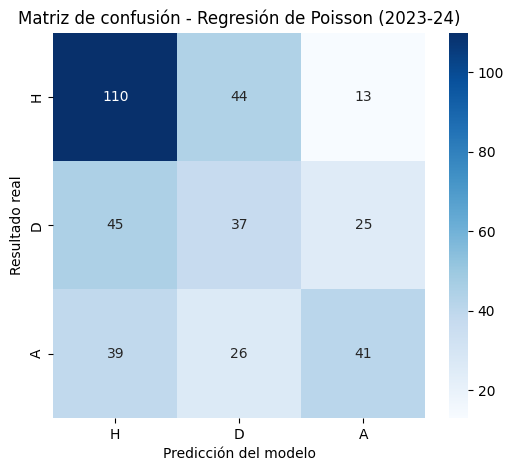

Reporte de clasificación (F1-score, precisión, recall):
              precision    recall  f1-score   support

           H      0.567     0.659     0.609       167
           D      0.346     0.346     0.346       107
           A      0.519     0.387     0.443       106

    accuracy                          0.495       380
   macro avg      0.477     0.464     0.466       380
weighted avg      0.491     0.495     0.489       380

F1-score macro: 0.466
Accuracy: 0.495


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Etiquetas de clases
etiquetas = ['H', 'D', 'A']

# Matriz de confusión
cm = confusion_matrix(df_preds_poisson_reg['result_real'], df_preds_poisson_reg['Pred'], labels=etiquetas)

# Visualización
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
plt.xlabel("Predicción del modelo")
plt.ylabel("Resultado real")
plt.title("Matriz de confusión - Regresión de Poisson (2023-24)")
plt.show()

# Reporte de clasificación
print("Reporte de clasificación (F1-score, precisión, recall):")
print(classification_report(
    df_preds_poisson_reg['result_real'],
    df_preds_poisson_reg['Pred'],
    labels=etiquetas,
    digits=3,
    zero_division=0
))

# F1 macro y precisión global
f1_macro = f1_score(
    df_preds_poisson_reg['result_real'],
    df_preds_poisson_reg['Pred'],
    labels=etiquetas,
    average='macro',
    zero_division=0
)

accuracy = (df_preds_poisson_reg['result_real'] == df_preds_poisson_reg['Pred']).mean()

print(f"F1-score macro: {f1_macro:.3f}")
print(f"Accuracy: {accuracy:.3f}")


#### Conclusión del rendimiento del modelo

El modelo de regresión de Poisson alcanza una precisión global del 49.5% y un F1-score macro de 0.466. Predice mejor las victorias locales (F1 = 0.609), mientras que el rendimiento en empates (F1 = 0.346) y victorias visitantes (F1 = 0.443) es más bajo. Esto indica que el modelo es razonablemente efectivo, especialmente en partidos donde el equipo local gana, pero tiene margen de mejora en resultados menos frecuentes o más inciertos.


#### Evaluación de la estrategia de apuestas basada en el modelo

Se ha simulado una estrategia de apuestas basada en las predicciones del modelo de regresión de Poisson, utilizando cuotas reales del mercado. El importe apostado (stake) depende de la probabilidad estimada: se apuestan 2 € si la probabilidad del resultado predicho es igual o superior a 0.6, y 1 € en caso contrario.

- **Apuestas acertadas**
- **Total gastado**
- **Total ganado**
- **Beneficio neto**
- **Rentabilidad**

Este análisis permite cuantificar la viabilidad del modelo como herramienta para generar beneficios en el mercado de apuestas, más allá de su rendimiento como clasificador.


In [20]:
# Añadir las cuotas desde df_test al DataFrame de predicciones
df_preds_poisson_reg[['AvgH', 'AvgD', 'AvgA']] = df_test[['AvgH', 'AvgD', 'AvgA']].reset_index(drop=True)

In [30]:
# Copiar predicciones
df_apuestas = df_preds_poisson_reg.copy()

# Añadir cuotas directamente desde df_test (están en el mismo orden)
df_apuestas[['AvgH', 'AvgD', 'AvgA']] = df_test[['AvgH', 'AvgD', 'AvgA']].reset_index(drop=True)

# Cuota usada según la predicción
df_apuestas['cuota_usada'] = df_apuestas.apply(
    lambda row: row['AvgH'] if row['Pred'] == 'H' else (
        row['AvgD'] if row['Pred'] == 'D' else row['AvgA']
    ),
    axis=1
)

# Acierto de la apuesta
df_apuestas['acierto'] = (df_apuestas['Pred'] == df_apuestas['result_real']).astype(int)

# Probabilidad del resultado predicho
df_apuestas['p_pred'] = df_apuestas.apply(
    lambda row: row['P_H'] if row['Pred'] == 'H' else (
        row['P_D'] if row['Pred'] == 'D' else row['P_A']
    ), axis=1
)

# Stake: 2 € si p_pred ≥ 0.6, si no 1 €
df_apuestas['stake'] = df_apuestas['p_pred'].apply(lambda p: 2 if p >= 0.6 else 1)

# Ganancia por apuesta
df_apuestas['ganancia'] = df_apuestas.apply(
    lambda row: row['cuota_usada'] * row['stake'] if row['acierto'] == 1 else 0,
    axis=1
)

# Resultados con impresión estilo unificado
acertadas = df_apuestas['acierto'].sum()
total_partidos = len(df_apuestas)
total_apostado = df_apuestas['stake'].sum()
total_ganado = df_apuestas['ganancia'].sum()
beneficio_neto = total_ganado - total_apostado
rentabilidad = (beneficio_neto / total_apostado) * 100

print(f"Apuestas acertadas: {acertadas} de {total_partidos}")
print(f"Total gastado: {total_apostado:.2f} €")
print(f"Total ganado: {total_ganado:.2f} €")
print(f"Beneficio neto: {beneficio_neto:.2f} €")
print(f"Rentabilidad: {rentabilidad:.2f} %")


Apuestas acertadas: 188 de 380
Total gastado: 466.00 €
Total ganado: 790.17 €
Beneficio neto: 324.17 €
Rentabilidad: 69.56 %
